# Load dataset

In [2]:
# Load Dataset

from datasets import load_dataset

ds = load_dataset("zoheb/sketch-scene")

split_ds = ds['train'].train_test_split(test_size = 0.1, seed=42)

train_ds = split_ds['train']
test_ds = split_ds['test']

/miniconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 9999
    })
})

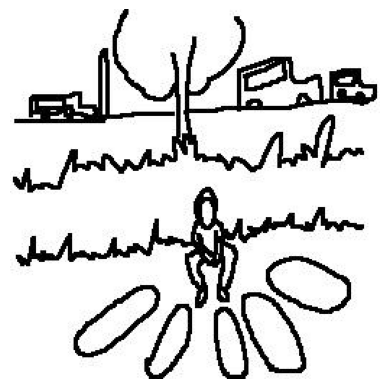

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x145A3394A330>, 'text': 'a person is sitting in front of surf boards'}


In [4]:
from PIL import Image
import matplotlib.pyplot as plt
sample = ds['train'][55]
img = sample["image"]

plt.imshow(img)
plt.axis("off")
plt.show()

print(sample) 


In [5]:
img.size

(256, 256)

# Create Data Loaders

In [6]:
from torchvision import transforms

IMG_SIZE = 64

# define transform
transforms_img = [transforms.Resize((64, 64)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5]) if img.mode == 'L'
                    else transforms.Normalize([0.5]*3, [0.5]*3)
            ]

transform = transforms.Compose(transforms_img)

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SketchDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img = self.ds[idx]['image']
        img = self.transform(img)
        return img

train_dataset = SketchDataset(train_ds, transform)
test_dataset = SketchDataset(test_ds, transform)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [8]:
x0 = next(iter(train_loader))
print(x0.shape, x0.min(), x0.max())


torch.Size([8, 3, 64, 64]) tensor(-1.) tensor(1.)


In [9]:
for batch in train_loader:
    for img in batch:
        print(img.shape)
        break
    break

torch.Size([3, 64, 64])


# Forward Diffusion process

In [21]:
import torch

# Move all vars to GPU

device = "cuda"

# diffusion steps
T = 10000


# define beta and alphas
betas = torch.linspace(0.0001, 0.02, T).to(device)
alphas = (1 - betas).to(device)
alpha_bar = torch.cumprod(alphas, dim=0).to(device)


def sample_time_steps(batchsize):
    return torch.randint(0, T, (batchsize, ), device="cuda")

# forward process

def forward_diffusion(x0, t, noise=None):
    if noise == None:
        noise = torch.randn_like(x0)

    # specific syntax to do scalar multiplication over a matrix or broadcasting a value across input
    # across C, H, W
    sqrt_ab = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_1mab = torch.sqrt(1-alpha_bar[t])[:, None, None, None]

    return sqrt_ab*x0 + sqrt_1mab*noise



In [22]:
# Chumma test
x0 = next(iter(train_loader)).cuda()
t = sample_time_steps(x0.size(0))
noise = torch.randn_like(x0)

x_t = forward_diffusion(x0, t, noise)
print(x_t.shape)
x_t

torch.Size([8, 3, 64, 64])


tensor([[[[ 0.4134,  0.4247,  0.0120,  ..., -0.4326,  0.4404,  0.1427],
          [ 0.4766, -0.1546,  0.7243,  ..., -1.6176, -0.8773,  0.8082],
          [-0.1272, -0.8537,  1.7279,  ...,  1.1418,  1.8108,  1.3282],
          ...,
          [ 2.1713,  0.1692, -0.1272,  ...,  1.3768,  0.8277, -0.4086],
          [-0.9596, -1.0102, -0.2323,  ...,  1.4733,  1.0176,  0.2991],
          [ 2.4055, -0.8361,  0.6767,  ..., -0.3847,  1.1412,  0.5976]],

         [[ 0.6899, -1.1809, -0.0890,  ..., -0.1102,  2.0238, -0.3318],
          [-0.1802,  0.9424, -1.0251,  ..., -0.5922, -1.6811,  0.0674],
          [-1.0011,  0.2844,  1.6927,  ...,  1.8546, -0.2683, -1.4185],
          ...,
          [-0.0370, -0.6124,  0.7771,  ...,  0.0425, -0.6392,  0.5167],
          [ 0.0471,  0.8364, -0.0054,  ...,  0.2881,  0.0883, -2.1334],
          [ 0.0690,  0.4054,  1.2615,  ..., -1.1002,  0.6926, -0.6785]],

         [[-0.7153, -0.4570,  0.9960,  ..., -0.6283, -0.6918, -2.0703],
          [ 2.4855,  1.1150,  

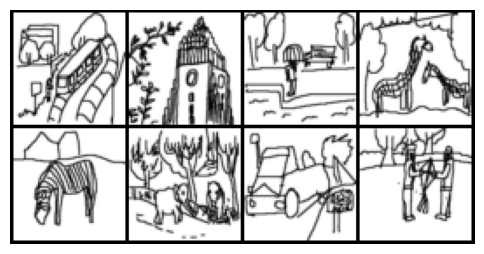

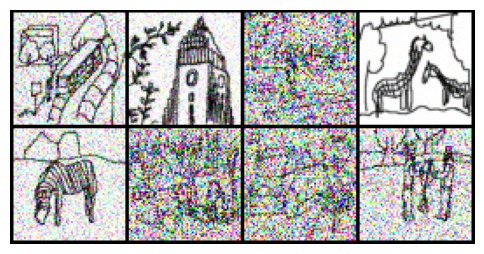

In [12]:
# Visualize

import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(x):
    grid = vutils.make_grid(x[:8], nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

# original
show_images(x0)

# with added noise
show_images(x_t)


# Reverse Process with U-Net

In [13]:
import math
import torch.nn as nn
import torch.nn.functional as F


# turn timestep into a vector embedding that the main U-NET can use
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.SiLU(), # swish activation fn
            nn.Linear(dim*4, dim)
        )

    def forward(self, t):
        # half sine and half cos waves
        half = self.dim//2

        freqs = torch.exp(-math.log(10000)* torch.arange(0, half, device=t.device) / half)

        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)


        # build embeddings
        embeddings = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

        return self.mlp(embeddings)

In [14]:
# Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.time_proj = nn.Linear(time_dim, out_channels)

        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels) 

        self.act = nn.SiLU()
        self.skip = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t_emb):

        h = self.conv1(x)
        t_out = self.time_proj(t_emb)
        h = h + t_out[:, :, None, None]
        h = self.norm1(h)
        h = self.act(h)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)
        return h + self.skip(x)


In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64, time_dim=256):
        super().__init__()

        self.time_mlp = TimeEmbedding(time_dim)

        # downsampling
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)

        self.down1 = ResBlock(base_channels, base_channels, time_dim)
        self.down2 = ResBlock(base_channels, base_channels * 2, time_dim)
        self.down3 = ResBlock(base_channels * 2, base_channels * 4, time_dim)
        self.downsample1 = nn.Conv2d(base_channels, base_channels, 4, stride=2, padding=1)
        self.downsample2 = nn.Conv2d(base_channels * 2, base_channels * 2, 4, stride=2, padding=1)
        self.downsample3 = nn.Conv2d(base_channels * 4, base_channels * 4, 4, stride=2, padding=1)

        # bottleneck
        self.mid1 = ResBlock(base_channels * 4, base_channels * 4, time_dim)
        self.mid2 = ResBlock(base_channels * 4, base_channels * 4, time_dim)

        # upsampling
        self.upsample3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 4, stride=2, padding=1)
        self.up3 = ResBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_dim)

        self.upsample2 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 4, stride=2, padding=1)
        self.up2 = ResBlock(base_channels * 2 + base_channels * 2, base_channels, time_dim)

        self.upsample1 = nn.ConvTranspose2d(base_channels, base_channels, 4, stride=2, padding=1)
        self.up1 = ResBlock(base_channels + base_channels, base_channels, time_dim)

        # output
        self.conv_out = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)  

        # down
        x0 = self.conv_in(x)           
        d1 = self.down1(x0, t_emb) 
        x_d1 = self.downsample1(d1)

        d2 = self.down2(x_d1, t_emb)
        x_d2 = self.downsample2(d2)

        d3 = self.down3(x_d2, t_emb)
        x_d3 = self.downsample3(d3)

        m = self.mid1(x_d3, t_emb)
        m = self.mid2(m, t_emb)

        # up
        u3 = self.upsample3(m)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.up3(u3, t_emb)

        u2 = self.upsample2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up2(u2, t_emb)

        u1 = self.upsample1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up1(u1, t_emb)

        out = self.conv_out(u1)
        return out


# Training

In [16]:
device = "cuda"

model = UNet(in_channels=3, base_channels=64, time_dim=128).to(device)
model = nn.DataParallel(model)

# eps_pred = model(x_t, t)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
num_epochs = 10


In [17]:
# training loop

for epoch in range(num_epochs):
    for x0 in train_loader:
        x0 = x0.to(device)

        # sample random timesteps for x0
        t = sample_time_steps(x0.size(0)).to(device)

        # random gaussian noise
        noise = torch.randn_like(x0)

        # diffusion (forward process)
        x_t = forward_diffusion(x0, t, noise)

        # predict noise

        noise_pred = model(x_t, t)

        loss = loss_fn(noise_pred, noise)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}/{num_epochs}, Loss: {loss.item()}")
    if(epoch %5 == 0):
        torch.save(model.state_dict(), f"ddpm_epoch_{epoch}.pth")

Epoch: 0/10, Loss: 391.947509765625
Epoch: 1/10, Loss: 140.0928955078125
Epoch: 2/10, Loss: 53.18606948852539
Epoch: 3/10, Loss: 21.147260665893555
Epoch: 4/10, Loss: 8.28126335144043
Epoch: 5/10, Loss: 9.297469139099121
Epoch: 6/10, Loss: 2.2333579063415527
Epoch: 7/10, Loss: 0.7450821399688721
Epoch: 8/10, Loss: 3.5960121154785156
Epoch: 9/10, Loss: 1.5414972305297852


# Inference

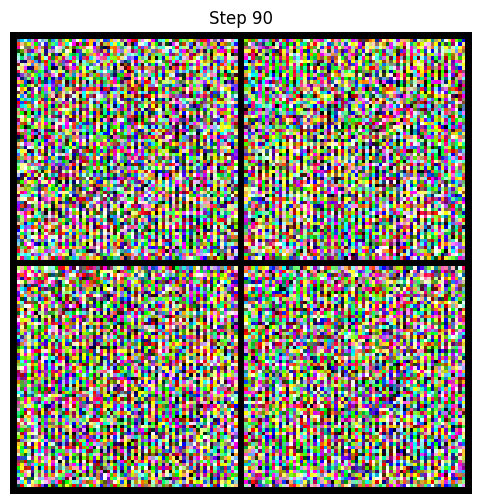

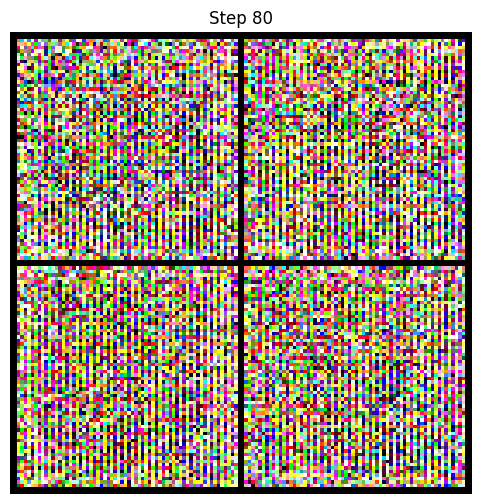

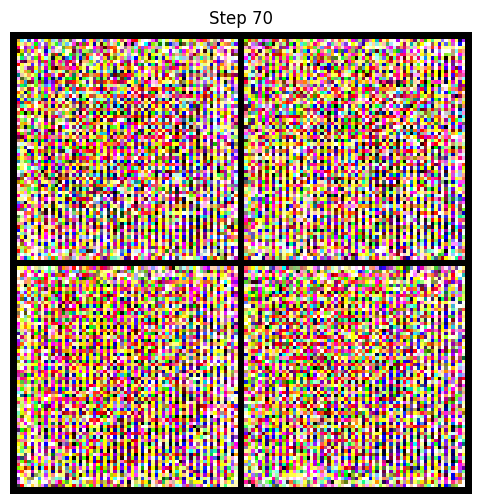

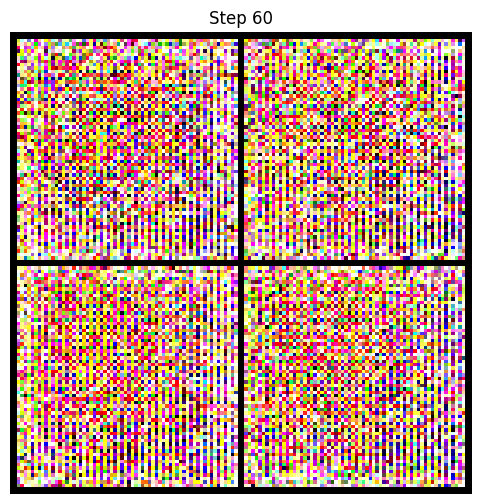

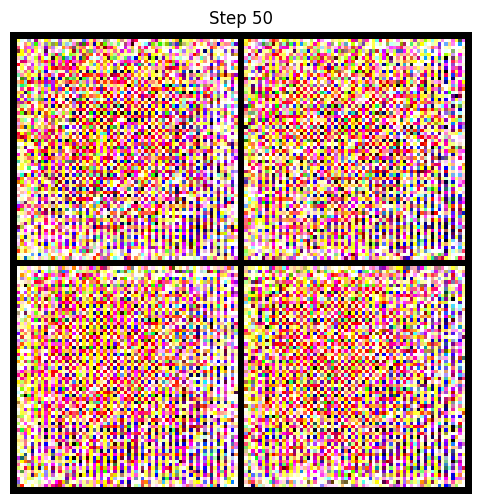

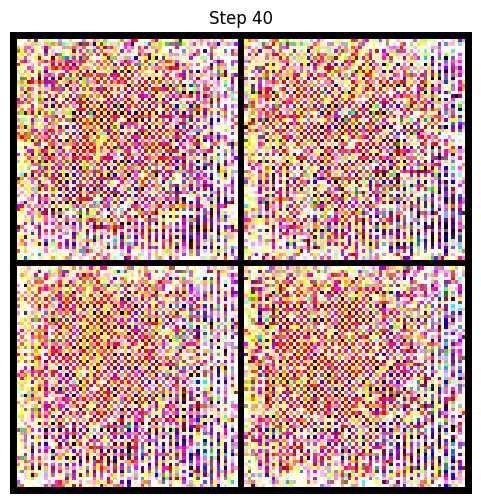

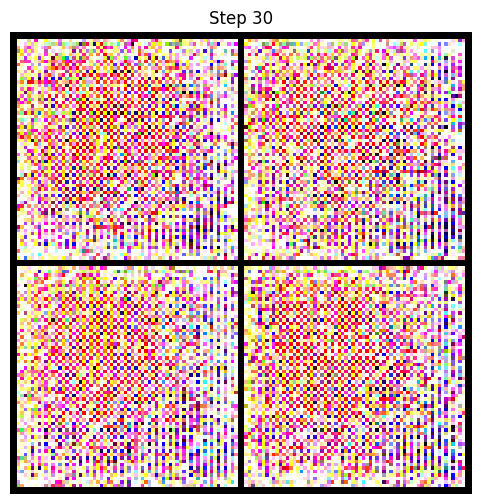

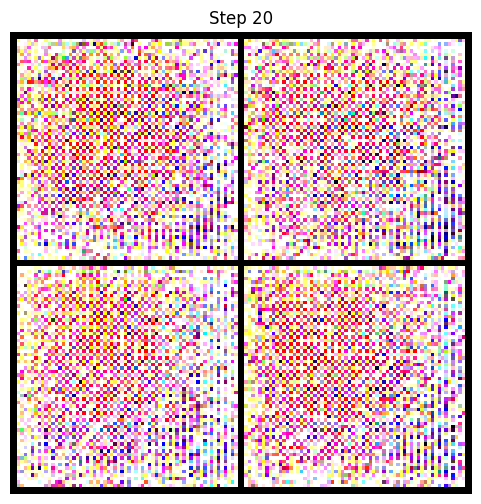

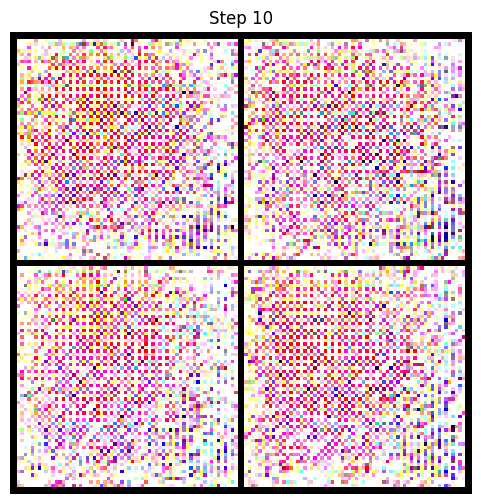

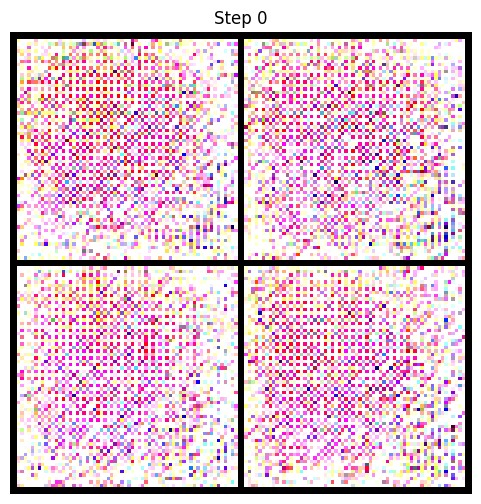

In [20]:
@torch.no_grad()
def p_sample(model, x_t, t):

    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bar[t]

    # predict noise at this time step
    eps_theta = model(x_t, torch.tensor([t], device=x_t.device).repeat(x_t.size(0)))

    # compute the DDPM mean
    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)

    mean = coef1 * (x_t - coef2 * eps_theta)

    # final step
    if t == 0:
        return mean
    noise = torch.randn_like(x_t)
    return mean + torch.sqrt(beta_t) * noise



@torch.no_grad()
def sample_images_progress(model, num_images=1, img_size=64, save_every=10):
    x = torch.randn(num_images, 3, img_size, img_size).to(device)

    all_samples = {}  # to store step → image

    for step in reversed(range(T)):   # T → 0
        x = p_sample(model, x, step)

        if step % save_every == 0 or step == 0:   # save at intervals
            # convert from [-1,1] to [0,1]
            x_vis = (x.clamp(-1, 1) + 1) / 2
            all_samples[step] = x_vis.clone().cpu()

    return all_samples


def show_progress(samples_dict):
    for step, imgs in sorted(samples_dict.items(), reverse=True):
        grid = vutils.make_grid(imgs, nrow=2)
        plt.figure(figsize=(6,6))
        plt.title(f"Step {step}")
        plt.imshow(grid.permute(1,2,0).numpy())
        plt.axis("off")
        plt.show()


model.eval()

samples_dict = sample_images_progress(
    model,
    num_images=4,
    img_size=64,
    save_every=10
)

show_progress(samples_dict)



In [25]:
import imageio
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torchvision.utils as vutils

def save_video(samples_dict, filename="diffusion_progress.mp4", fps=10):
    frames = []

    # optional: choose a font (default works too)
    try:
        font = ImageFont.truetype("arial.ttf", 32)
    except:
        font = ImageFont.load_default()

    # sorted from T → 0
    for step, imgs in sorted(samples_dict.items(), reverse=True):
        # make grid
        grid = vutils.make_grid(imgs, nrow=2)

        # convert tensor → numpy
        frame = (grid.permute(1,2,0).numpy() * 255).astype(np.uint8)

        # convert to PIL image
        pil_img = Image.fromarray(frame)

        # create drawable layer
        draw = ImageDraw.Draw(pil_img)

        # Add text "step = XXX"
        draw.text(
            (10, 10),                   # position
            f"step = {step}",           # text
            fill=(255, 255, 255),       # white text
            font=font
        )

        # convert back to numpy
        frames.append(np.array(pil_img))

    # save the video
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved video to {filename}")


save_video(samples_dict)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (134, 134) to (144, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video to diffusion_progress.mp4
